<a href="https://colab.research.google.com/github/Manuel-FA/Deep_Learning/blob/main/Car_Object_Detection_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!git clone 'https://github.com/Manuel-FA/Deep_Learning.git'

Cloning into 'Deep_Learning'...


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os
import random
import warnings
warnings.filterwarnings("ignore")

In [ ]:
print('Image(Train):',len(os.listdir("/content/drive/MyDrive/Datasets/training_images")))
print('Image(Test):',len(os.listdir("/content/drive/MyDrive/Datasets/testing_images")))

Image(Train): 1001
Image(Test): 175


In [ ]:
Data=pd.read_csv("/content/train_solution_bounding_boxes.csv")

In [ ]:
Data.head()

image        xmin        ymin        xmax        ymax
0   vid_4_1000.jpg  281.259045  187.035071  327.727931  223.225547
1  vid_4_10000.jpg   15.163531  187.035071  120.329957  236.430180
2  vid_4_10040.jpg  239.192475  176.764801  361.968162  236.430180
3  vid_4_10020.jpg  496.483358  172.363256  630.020260  231.539575
4  vid_4_10060.jpg   16.630970  186.546010  132.558611  238.386422

In [ ]:
print('Train data localization:',len(Data))

Train data localization: 559


SE VIZULIZA UNA IMAGEN CON LAS COORRDENADAS DE LO QUE SE ENCUENTRA EN EL CSV

Photo shape: (380, 676, 3)
Name,xmin,ymin,xmax,ymax: ['vid_4_1000.jpg' 281.2590449 187.0350708 327.7279305 223.225547]


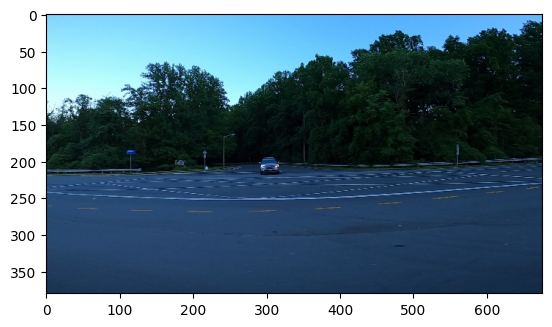

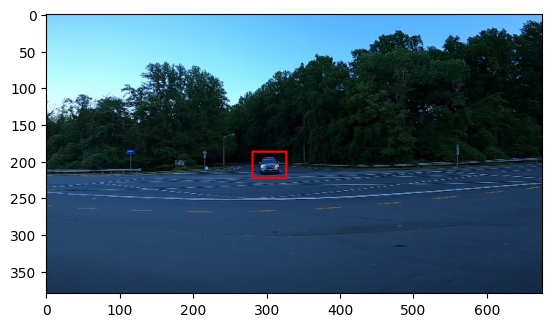

In [ ]:
for i in Data.values:
  photo=plt.imread(f'/content/drive/MyDrive/Datasets/training_images/{i[0]}')
  plt.imshow(photo)
  print('Photo shape:',photo.shape)
  print('Name,xmin,ymin,xmax,ymax:',i)
  pt1=(int(i[1]),int(i[2]))
  pt2=(int(i[3]),int(i[4]))
  color=(255, 0, 0)
  thickness = 2
  cv2.rectangle(photo,pt1,pt2, color, thickness)
  plt.figure()
  plt.imshow(photo)
  break

Este hace lo mismo pero con 3

(380, 676, 3)
(380, 676, 3)
(380, 676, 3)


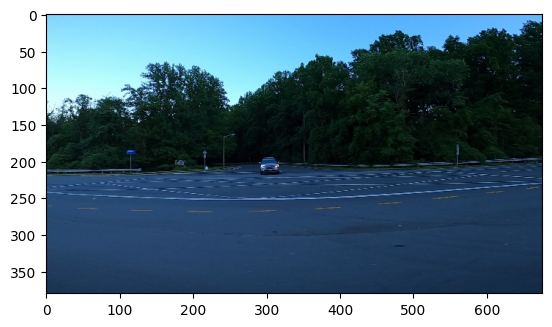

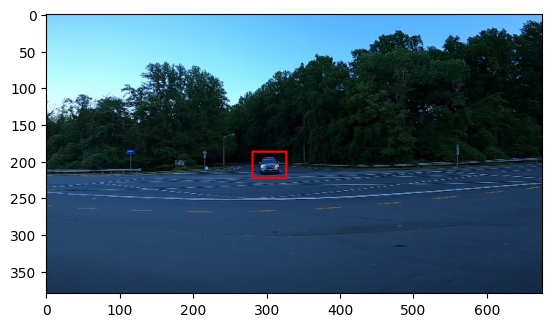

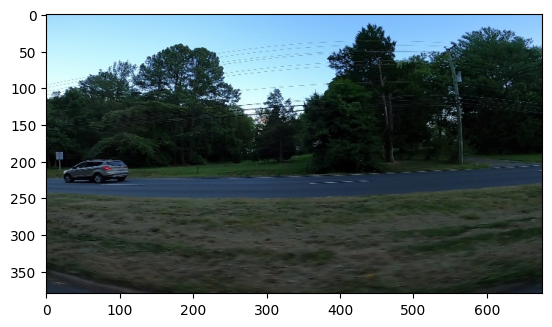

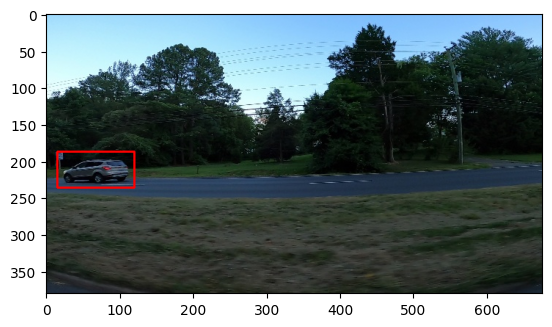

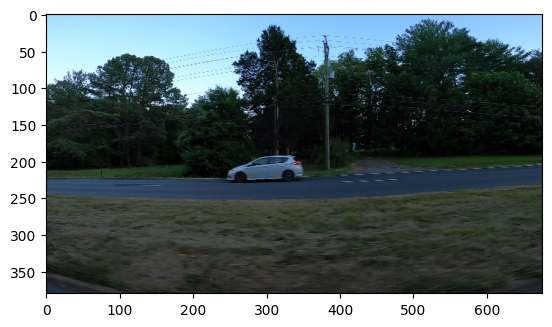

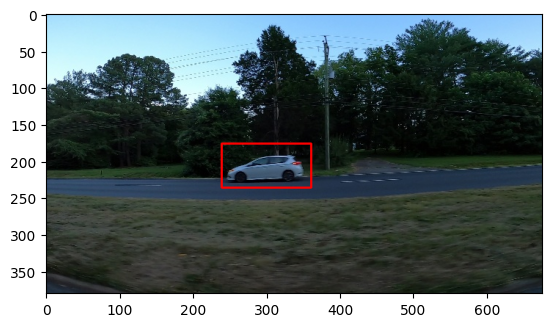

In [ ]:
for a,i in enumerate(Data.values):
  img=plt.imread('/content/drive/MyDrive/Datasets/training_images/'+i[0])
  print(img.shape)
  plt.figure()
  plt.imshow(img)
  xmin=int(i[1])
  ymin=int(i[2])
  xmax=int(i[3])
  ymax=int(i[4])
  cv2.rectangle(img,(xmin, ymin),(xmax, ymax),(255, 0, 0),2)
  plt.figure()
  plt.imshow(img)
  if a ==2:
    break

on el módulo ximgproc para realizar una segmentación de imágenes utilizando el algoritmo "Selective Search". Este algoritmo es una técnica popular para proponer regiones de interés (RoIs) en imágenes para aplicaciones de detección de objetos.

In [ ]:
cv2.setUseOptimized(True) # Optimeze
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation() # Selective search obje

 este código utiliza Selective Search para proponer regiones de interés en una imagen y luego muestra la imagen original con rectángulos verdes alrededor de cada región propuesta, SOLO PARA UNA IMAGEN, TENGO LA DUDA SI ESTO SIRVE PARA  ALGO EN ESPECIAL

Shape: (224, 224, 3)
possible bounty boxes: 213


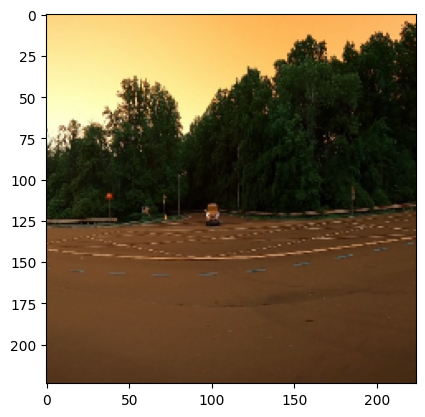

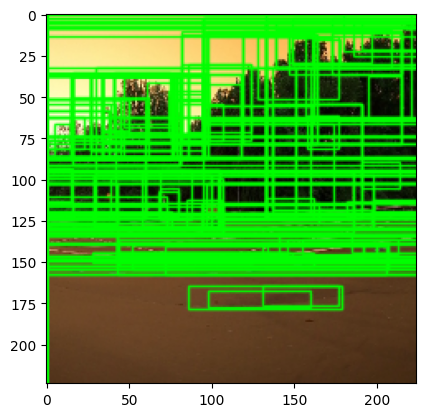

In [ ]:
im = cv2.imread('/content/drive/MyDrive/Datasets/training_images/vid_4_1000.jpg')
im=cv2.resize(im,(224,224))
plt.figure()
plt.imshow(im)
ss.setBaseImage(im) # GÖrüntünün yüklendiği kısım
ss.switchToSelectiveSearchFast() # Selective Search süresini hızlandırmak için
rects = ss.process()
print('Shape:',im.shape)
print('possible bounty boxes:',len(rects))

for rect in rects:
  x, y, w, h = rect
  imOut=cv2.rectangle(im, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
plt.figure()
plt.imshow(imOut);

In [ ]:
#Iou and selective search
cv2.setUseOptimized(True)
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
def get_iou(bb1, bb2):

    assert bb1['x1'] < bb1['x2'] #bb1
    assert bb1['y1'] < bb1['y2']

    assert bb2['x1'] < bb2['x2'] #bb2
    assert bb2['y1'] < bb2['y2'];

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
      return 0.0
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [ ]:
image_liste=[]
k=0
l=0
z=0 #Loading
for a in pd.read_csv('/content/train_solution_bounding_boxes.csv').values:
  Name,xmin,ymin,xmax,ymax=a
  bb1={ #gerçek bounty boxxes
            'x1':int(xmin),
            'y1':int(ymin),
            'x2':int(xmax),
            'y2':int(ymax)
            }
  try:
    img=cv2.imread('/content/drive/MyDrive/Datasets/training_images/'+Name)
    ss.setBaseImage(img)
    ss.switchToSelectiveSearchFast()
    rects = ss.process()
    for i in rects:
      x, y, w, h = i # Selective bounty boxxes
      bb2={'x1':x,
          'y1':y,
          'x2':x+w,
          'y2':y+h
          }
      img1=img[bb2['y1']:bb2['y2'],bb2['x1']:bb2['x2']] # Crop img
      img1_shape=cv2.resize(img1,(224,224))
      if k<l:
            if 0.5<get_iou(bb1,bb2):
              image_liste.append([img1_shape,1])
              k+=1
      else:
        if 0.5<get_iou(bb1,bb2):
          image_liste.append([img1_shape,1])
          k+=1
        else:
          image_liste.append([img1_shape,0])
          l+=1
  except Exception as e:
    print('hata var',e)
  z+=1
  print(Name,z,len(rects))

vid_4_1000.jpg 1 1101
vid_4_10000.jpg 2 1456
vid_4_10040.jpg 3 1403
vid_4_10020.jpg 4 1489
vid_4_10060.jpg 5 1315
vid_4_10100.jpg 6 1537
vid_4_10120.jpg 7 1430
vid_4_10140.jpg 8 1544
vid_4_1020.jpg 9 1117
vid_4_1040.jpg 10 1146
vid_4_10480.jpg 11 1663
vid_4_10500.jpg 12 1815
vid_4_10520.jpg 13 1725
vid_4_1060.jpg 14 1251
vid_4_10960.jpg 15 1894
vid_4_10980.jpg 16 1676
vid_4_11000.jpg 17 1754
vid_4_11020.jpg 18 1553
vid_4_11240.jpg 19 1779
vid_4_11260.jpg 20 1863
vid_4_11280.jpg 21 1846
vid_4_11380.jpg 22 1884
vid_4_11400.jpg 23 1929
vid_4_11420.jpg 24 1925
vid_4_11440.jpg 25 1880
vid_4_11900.jpg 26 1801
vid_4_11880.jpg 27 1824
vid_4_11920.jpg 28 1857
vid_4_11940.jpg 29 1947
vid_4_11960.jpg 30 1932
vid_4_11980.jpg 31 1970
vid_4_12000.jpg 32 1901
vid_4_12040.jpg 33 1979
vid_4_12100.jpg 34 1971
vid_4_12060.jpg 35 1879
vid_4_12080.jpg 36 1870
vid_4_12120.jpg 37 1821
vid_4_12140.jpg 38 1632
vid_4_12140.jpg 39 1632
vid_4_12160.jpg 40 1682
vid_4_12160.jpg 41 1682
vid_4_12160.jpg 42 1682
vid_4

In [ ]:
len(image_liste)

NameError: ignored

In [ ]:
data=[]
data_label=[]
for features,label in image_liste:
  data.append(features)
  data_label.append(label)
print('işlem başarılı')

işlem başarılı


In [ ]:
print('Fotoğraf sayısı:',len(data),'|Label sayısı:',len(data_label))

Fotoğraf sayısı: 10581 |Label sayısı: 10581


Class: 0
Görüntü boyutu: (224, 224, 3)


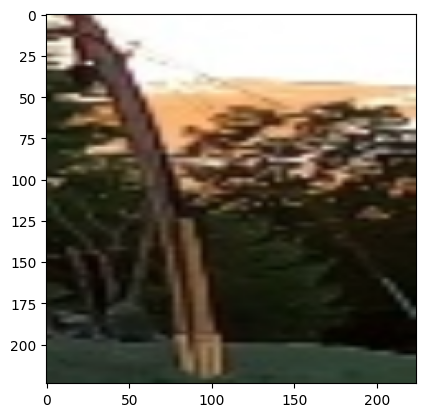

In [ ]:
i=random.randint(1,10583)
print('Class:',data_label[i])
print('Görüntü boyutu:',data[i].shape)
plt.imshow(data[i]);

In [ ]:
data=np.asarray(data)
data_label=np.asarray(data_label)

In [ ]:
print('Araba görüntüsü yok:',len(data_label[data_label==0]),'|Araba görüntüsü var:',len(data_label[data_label==1]))

In [ ]:
data.shape

In [ ]:
data_label.shape

In [ ]:
from sklearn.model_selection import train_test_split

x_train,x_val,y_train,y_val=train_test_split(data,data_label,test_size=0.33, random_state=42)

In [ ]:
print('x_train shape:',x_train.shape)
print('x_val shape:',x_val.shape)
print('y_train shape:',y_train.shape)
print('y_val shape:',y_val.shape)

In [ ]:
base_model=tf.keras.applications.VGG16(include_top=False,input_shape=(224,224,3),weights='imagenet')

In [ ]:
base_model.summary()

In [ ]:
model=tf.keras.Sequential()
model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

In [ ]:
model.summary()

In [ ]:
base_model.trainable=False

In [ ]:
for i,layer in enumerate(base_model.layers):
  print(i,layer.name,'-',layer.trainable)

In [ ]:
model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(),metrics='accuracy')

In [ ]:
epoch=4
hist=model.fit(x_train,y_train,epochs=epoch,validation_data=(x_val,y_val))

In [ ]:
car=[]
photo_path='../input/car-object-detection/data/testing_images/vid_5_27620.jpg'
deneme_img=cv2.imread(photo_path)
ss.setBaseImage(deneme_img)
ss.switchToSelectiveSearchFast()
rects1 = ss.process()
print('Fotoğraftaki muhtemel obje sayısı: ',len(rects1))
for i in rects1:
  x, y, w, h = i
  bb3={'x1':x,
        'y1':y,
        'x2':x+w,
        'y2':y+h
      }
  try:
    assert bb3['x1'] < bb3['x2']
    assert bb3['y1'] < bb3['y2']
    img_data=deneme_img[bb3['y1']:bb3['y2'],bb3['x1']:bb3['x2']]
    img_data=cv2.resize(img_data,(224,224))
    tahmin=model.predict(img_data.reshape(1,224,224,3))
    if tahmin[0]>0.5:
      car.append([bb3,tahmin[0]])
    else:
      pass
  except Exception as e:
    print('hata',e)
print('kaç adet class tahmini 1 olan muhtemel bounty box var:',len(car))
print('-------------------------------------------------------------------------')
deneme_img=cv2.imread(photo_path)
car[np.argmax(np.array(car)[:,1])][0]
pt1=(car[np.argmax(np.array(car)[:,1])][0]['x1'],car[np.argmax(np.array(car)[:,1])][0]['y1'])
pt2=(car[np.argmax(np.array(car)[:,1])][0]['x2'],car[np.argmax(np.array(car)[:,1])][0]['y2'])
plt.figure()
plt.imshow(deneme_img)
cv2.rectangle(deneme_img,pt1,pt2,(255, 0, 0),2)
plt.figure()
plt.title(f'Class numarası 1 olup ihtimal oranı en yüksek bounty box score: %{car[np.argmax(np.array(car)[:,1])][1][0]*100}')
plt.imshow(deneme_img);

Este es elnuevo texto que se debe de mostrar después del comit

In [ ]:
!git commit -m "commit test"

fatal: not a git repository (or any of the parent directories): .git


In [1]:
este es otro cambio para testear el cfomit

SyntaxError: ignored